# **Introduction to ML Pipelines**

---



## **Data Import**

Up to now, we have used fairly straightforward datasets with a handful of variables. However, what if we have a dataset as below with over **80 variables**, many of which are repeated values, and missing data? **Pipelines** are a way to create functions to simply plug a large dataset into functions to do all of the work for us on large datasets.

In [1]:
def import_data(path, messages=True):
  import pandas as pd

  df = pd.read_csv(path)

  # Messages like these are useful when building out the pipeline initially
  # But they can be turned off once the pipeline is ready
  if messages: print(df.shape)

  return df

In [2]:
# Call the funtion here to test it; however, we will use it again later
import pandas as pd
pd.set_option('display.max_columns', 10)
df = import_data('https://www.ishelp.info/data/housing_full.csv')
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,...,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,...,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,...,12,2008,WD,Normal,250000


Take a look at the number of columns below. This is a **ton** of information that needs to be worked through quickly.

In [3]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'TotalSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive',

## **Data Understanding**

**Know Thy Data**: The following function is a way to quickly see an overview of all numerical and categorical data. You might have to save the image or change some of the settings to see the entire image.

This is a way to look for abnormal data. For example, you can see at a glance which variables are highly skewed or those that are more normally distributed. You can also see which variables have high numbers of missing data.

In [4]:
def univariate(df, sample=500):
  import seaborn as sns
  import matplotlib.pyplot as plt
  import math

  df_results = pd.DataFrame(columns=['bin_groups', 'type', 'missing', 'unique', 'min',
                                    'median', 'max', 'mode', 'mean', 'std', 'skew'])

  for col in df:
    # Features that apply to all dtypes
    dtype = df[col].dtype
    missing = df[col].isna().sum()
    unique = df[col].nunique()
    mode = df[col].mode()[0]
    if pd.api.types.is_numeric_dtype(df[col]):
      # Features for numeric dtypes only
      min = df[col].min()
      max = df[col].max()
      mean = df[col].mean()
      median = df[col].median()
      std = df[col].std()
      skew = df[col].skew()
      df_results.loc[col] = ['-', dtype, missing, unique, min, median, max, mode,
                            round(mean, 2), round(std, 2), round(skew, 2)]
    else:
      # Features for object dtypes only
      flag = df[col].value_counts()[(df[col].value_counts() / df.shape[0]) < 0.05].shape[0]
      df_results.loc[col] = [flag, dtype, missing, unique, '-', '-', '-', mode, '-', '-', '-']

  # Make a sub-DataFrame of features that are objects or have only two values; they will need countplots
  countplots = df_results[(df_results['type']=='object') | (df_results['unique']==2)]
  # Make a sub-DataFrame of features that are floats or ints with many values which will need histograms
  histograms = df_results[(df_results['type']=='float64') | ((df_results['unique']>10) & (df_results['type']=='int64'))]
  histograms = histograms[histograms['unique']>2] # Remove those that are binary

  # Create a set of countplots for the categorical features
  f, ax = plt.subplots(1, countplots.shape[0], figsize=[countplots.shape[0] * 1.5, 1.5])
  for i, col in enumerate(countplots.index):
    g = sns.countplot(data=df, x=col, color='g', ax=ax[i]);
    g.set_yticklabels('')
    g.set_ylabel('')
    ax[i].tick_params(labelrotation=90, left=False)
    ax[i].xaxis.set_label_position('top')
    sns.despine(left=True, top=True, right=True)

  plt.subplots_adjust(hspace=2, wspace=.5)
  plt.show()

  # Create a set of histograms for the numeric features
  f, ax = plt.subplots(1, histograms.shape[0], figsize=[histograms.shape[0] * 1.5, 1.5])
  for i, col in enumerate(histograms.index):
    g = sns.histplot(data=df.sample(n=sample, random_state=1), x=col, color='b', ax=ax[i], kde=True);
    g.set_yticklabels(labels=[])
    g.set_ylabel('')
    ax[i].tick_params(left=False)
    sns.despine(left=True, top=True, right=True)

  plt.subplots_adjust(hspace=2, wspace=.5)
  plt.show()

  return df_results

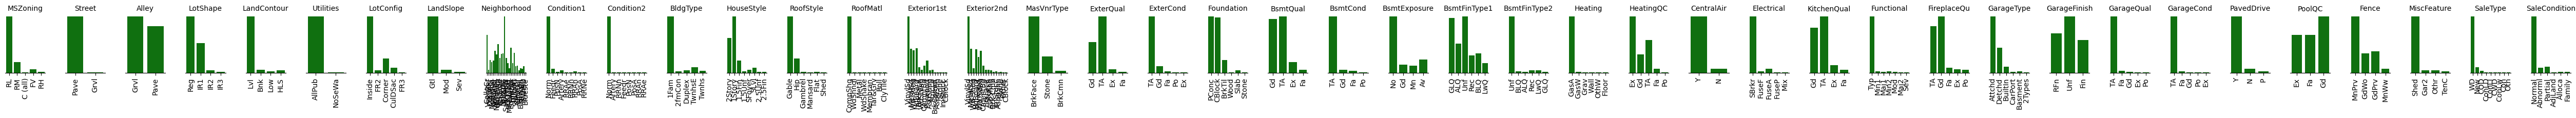

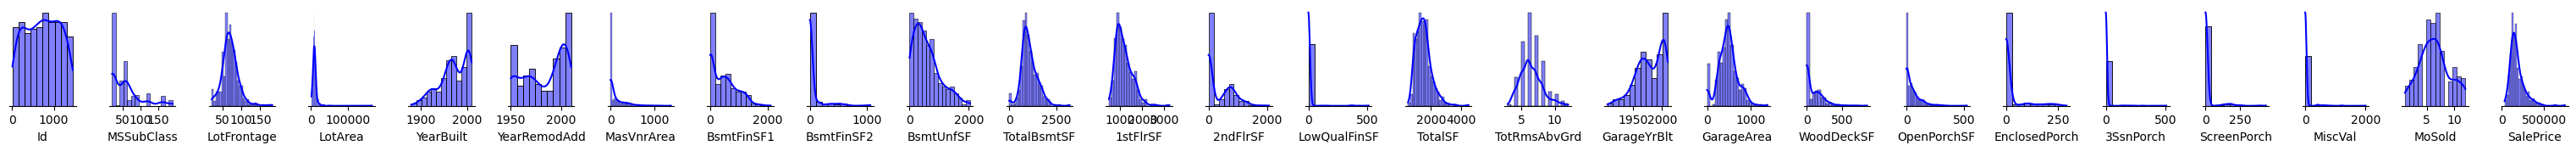

,bin_groups,type,missing,unique,min,median,max,mode,mean,std,skew
Id,-,int64,0,1460,1,730.5,1460,1,730.5,421.61,0.0
MSSubClass,-,int64,0,15,20,50.0,190,20,56.9,42.3,1.41
MSZoning,3,object,0,5,-,-,-,RL,-,-,-
LotFrontage,-,float64,259,110,21.0,69.0,313.0,60.0,70.05,24.28,2.16
LotArea,-,int64,0,1073,1300,9478.5,215245,7200,10516.83,9981.26,12.21
Street,1,object,0,2,-,-,-,Pave,-,-,-
Alley,2,object,1369,2,-,-,-,Grvl,-,-,-
LotShape,2,object,0,4,-,-,-,Reg,-,-,-
LandContour,3,object,0,4,-,-,-,Lvl,-,-,-
Utilities,1,object,0,2,-,-,-,AllPub,-,-,-


In [5]:
# We will repeat the full pipline each time as a reminder that it includes all functions:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = import_data('housing_full.csv', messages=False)
univariate(df)

## **Data Preparation**

### Binning Categorial Features

It's hard enough to use a binning technique on one variable, but what about multiple categorical variables? Here's a way to streamline the binning process across an entire dataset! Now, all of the categorical variables are binned according to your settings.

In this function, any category that makes up less than 5% of the variable is grouped together into an "Other" category. You can change the cutoff or label if you'd like.

In [6]:
def bin_groups(df, features=[], cutoff=0.05, replace_with='Other', messages=True):
  import pandas as pd

  if len(features) == 0: features = df.columns

  for feat in features:
    if feat in df.columns:  # Make sure they don't accidentally enter a feature name that doesn't exist
      if not pd.api.types.is_numeric_dtype(df[feat]):
        other_list = df[feat].value_counts()[df[feat].value_counts() / df.shape[0] < cutoff].index
        if len(other_list) > 0:
          df.loc[df[feat].isin(other_list), feat] = replace_with
          if messages and len(other_list) > 0: print(f'{feat} has been binned by setting {other_list.values} to {replace_with}')
    else:
      if messages: print(f'{feat} not found in the DataFrame provided. No binning performed')

  return df

In [7]:
# Call the function to update the DataFrame
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df, cutoff=0.05)

MSZoning has been binned by setting ['FV' 'RH' 'C (all)'] to Other
Street has been binned by setting ['Grvl'] to Other
Alley has been binned by setting ['Grvl' 'Pave'] to Other
LotShape has been binned by setting ['IR2' 'IR3'] to Other
LandContour has been binned by setting ['Bnk' 'HLS' 'Low'] to Other
Utilities has been binned by setting ['NoSeWa'] to Other
LotConfig has been binned by setting ['FR2' 'FR3'] to Other
LandSlope has been binned by setting ['Mod' 'Sev'] to Other
Neighborhood has been binned by setting ['SawyerW' 'BrkSide' 'Crawfor' 'Mitchel' 'NoRidge' 'Timber' 'IDOTRR'
 'ClearCr' 'StoneBr' 'SWISU' 'MeadowV' 'Blmngtn' 'BrDale' 'Veenker'
 'NPkVill' 'Blueste'] to Other
Condition1 has been binned by setting ['Artery' 'RRAn' 'PosN' 'RRAe' 'PosA' 'RRNn' 'RRNe'] to Other
Condition2 has been binned by setting ['Feedr' 'Artery' 'RRNn' 'PosN' 'PosA' 'RRAn' 'RRAe'] to Other
BldgType has been binned by setting ['Duplex' 'Twnhs' '2fmCon'] to Other
HouseStyle has been binned by setting

### Missing Values

#### Drop rows and columns with too many missing values

We don't want to simply drop any column or row with any missing values, but columns or rows with high amounts of missing values are simply useless. This function will go through the dataset and drop any columns or rows with higher amounts of missing data, according to the settings that you set.

In [8]:
def missing_drop(df, label, row_thresh=0.7, col_thresh=0.9, drop_all=False):
  # Drop any row that has a missing label
  df.dropna(axis='rows', subset=[label], inplace=True)

  # Drop rows and columns have are 100% missing
  df.dropna(axis='columns', thresh=1, inplace=True)
  df.dropna(axis='rows', thresh=1, inplace=True)

  # Drop rows and columns that are below the thresholds
  df.dropna(axis='columns', thresh=round(df.shape[0] * row_thresh), inplace=True)
  df.dropna(axis='rows', thresh=round(df.shape[1] * col_thresh), inplace=True)

  # If you don't want to leave anything behind to impute:
  if drop_all:
    df.dropna(axis='rows', inplace=True)

  # Return the DataFrame
  return df

In [9]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df.isna().sum()[df.isna().sum() > 0]  # Show remaining columns that still have missing values

LotFrontage     259
MasVnrArea        8
BsmtQual         30
BsmtCond         30
BsmtExposure     31
BsmtFinType1     30
BsmtFinType2     31
Electrical        1
GarageType       74
GarageYrBlt      74
GarageFinish     74
GarageQual       74
GarageCond       74
dtype: int64

#### Replace with Mean, Median, or Mode: SimpleImputer

You still need to deal with missing data. Here are some functions that streamline imputing missing data, either by imputing the mean, median, or mode.

In [10]:
def Xandy(df, label):
  import pandas as pd
  y = df[label]
  X = df.drop(columns=[label])
  return X, y

In [11]:
def dummy_code(X):
  import pandas as pd
  X = pd.get_dummies(X, drop_first=True)
  return X

In [12]:
def impute_simple(df, label, strategy='median'):
  from sklearn.impute import SimpleImputer
  import pandas as pd, numpy as np

  # Dummy code first; categorical features not allowed
  X, y = Xandy(df, label)
  X = dummy_code(X.copy())

  # Change the strategy to mean, median, or mode
  imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
  X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

  return X.merge(y, left_index=True, right_index=True)

In [13]:
# Run the pipeline with missing_drop and impute_simple
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df_si = impute_simple(df, 'SalePrice') # Make a separate version of the data that has been SimpleImputed
df_si.isna().sum()[df_si.isna().sum() > 0]  # Show remaining columns that still have missing values

Series([], dtype: int64)

#### Missing Value Imputation: Multivariate

The following are stronger multivariate methods to impute data, either through clustering or regression. Refer back to BUSA 321 for details on these methods.

KNN Clustering-Based Imputation: **KNNImputer**

In [14]:
def minmax(X):
  import pandas as pd
  from sklearn.preprocessing import MinMaxScaler
  X = pd.DataFrame(MinMaxScaler().fit_transform(X.copy()), columns=X.columns, index=X.index)
  return X

In [15]:
def impute_KNN(df, label, neighbors=5):
  from sklearn.impute import KNNImputer

  import pandas as pd

  # Dummy code first; categorical features not allowed
  X, y = Xandy(df, label)
  X = dummy_code(X.copy())

  # Clustering is biased by unstandardized data; so MinMax scale it
  X = minmax(X.copy())

  # Lower values for n_neighbors mean higher accuracy, but greater chance of overfitting
  imp = KNNImputer(n_neighbors=neighbors, weights="uniform")
  X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

  # Return a version of the df with the y and X merged back together
  return X.merge(y, left_index=True, right_index=True)

In [16]:
# Run the pipeline with impute_KNN
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df_knn = impute_KNN(df, 'SalePrice') # Make a separate version of the data that has been KNNImputed
df_knn.isna().sum()[df_knn.isna().sum() > 0]  # Show remaining columns that still have missing values

Series([], dtype: int64)

Regression-Based Imputation: **IterativeImputer**

In [17]:
def impute_II(df, label, random_state=1):
  from sklearn.experimental import enable_iterative_imputer
  from sklearn.impute import IterativeImputer
  import pandas as pd

  # Dummy code first; categorical features not allowed
  X, y = Xandy(df, label)
  X = dummy_code(X.copy())

  # Scaling is unnecessary for regression-based imputation

  imp = IterativeImputer(max_iter=10, random_state=random_state)
  X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

  return X.merge(y, left_index=True, right_index=True)

In [18]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df_II = impute_II(df, 'SalePrice') # Make a separate version of the data that has been IterativeImputed
df_II.isna().sum()[df_II.isna().sum() > 0]  # Show remaining columns that still have missing values

Series([], dtype: int64)

### Compare Impute Speed

**ms** = milliseconds

In [19]:
%timeit impute_simple(df, 'SalePrice')
%timeit impute_KNN(df, 'SalePrice')
%timeit impute_II(df, 'SalePrice')

18.2 ms ± 749 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.3 ms ± 513 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.38 s ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## **Model Fitting**

There are **multiple** types of models that can be run. We will cover this in a later chapter. The following compares the score for each type of model used on the data to see which is the best. Remember, the **score** is based on the accuracy of the model created by the training data using the test data.

In [20]:
def split_data(X, y, test_size=0.3, random_state=1):
  import pandas as pd
  from sklearn.model_selection import train_test_split

  return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [21]:
def fit_split_regression(df, label, algorithm='ensemble', test_size=.2, random_state=1, messages=True):
  import pandas as pd

  # Just in case no cleaning has been performed
  df = bin_groups(df, messages=False)
  df = missing_drop(df, label, drop_all=True)

  # Prepare for modeling
  X, y = Xandy(df, label)
  X = dummy_code(X)

  # Split data
  X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

  # Choose an algorithm family and try two common algorithms
  if algorithm == 'linear':
    from sklearn.linear_model import Ridge, LassoLars
    model1 = Ridge(random_state=random_state).fit(X_train, y_train)
    model2 = LassoLars(random_state=random_state).fit(X_train, y_train)
  elif algorithm == 'ensemble':
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    model1 = RandomForestRegressor(random_state=random_state).fit(X_train, y_train)
    model2 = GradientBoostingRegressor(random_state=random_state).fit(X_train, y_train)
  else:
    from sklearn.neural_network import MLPRegressor
    from sklearn.neighbors import KNeighborsRegressor
    model1 = KNeighborsRegressor().fit(X_train, y_train)
    model2 = MLPRegressor(random_state=random_state, max_iter=10000).fit(X_train, y_train)

  score1 = model1.score(X_test, y_test)
  score2 = model2.score(X_test, y_test)

  if messages:
    print('R2', '{: <25}'.format(type(model1).__name__), round(score1, 4))
    print('R2', '{: <25}'.format(type(model2).__name__), round(score2, 4))

  if score1 > score2:
    return model1
  else:
    return model2

**Activity**: Do a quick Google search on some of the following regressor models. What are they? How are they different from one another? (Again, we will cover this a little more in a later chapter)

In [22]:
model = fit_split_regression(df, 'SalePrice', algorithm='linear')
model = fit_split_regression(df, 'SalePrice', algorithm='other')
model = fit_split_regression(df, 'SalePrice', algorithm='ensemble')

R2 Ridge                     0.8558
R2 LassoLars                 0.8503


c:\Users\ZyroY\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ZyroY\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ZyroY\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ZyroY\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ZyroY\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

R2 KNeighborsRegressor       0.5846
R2 MLPRegressor              0.7613
R2 RandomForestRegressor     0.8795
R2 GradientBoostingRegressor 0.8923


**K-fold Cross Validation**: You can choose how many (k) splits of the data to train and test models. The score for each of these models is averaged for a final score. For example, if k=5, then the data is split into 5 groups, each one with its own trained and tested model, along with its own score. All five model scores are averaged.

NOTE: This will take a while to run.

**Activity**: Try this when repeat=True. This will use repeated k-fold, meaning each of the k splits are THEN split into five more splits, repeating the process of training, testing, scoring, and averaging.

In [23]:
def fit_cv_regression(df, k, label, repeat=True, algorithm='ensemble', random_state=1, messages=True):
  from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
  import pandas as pd
  from numpy import mean

  # Just in case no cleaning has been performed
  df = bin_groups(df, messages=False)
  df = missing_drop(df, label, drop_all=True)

  # Prepare for modeling
  X, y = Xandy(df, label)
  X = dummy_code(X)

  # Create cross-validator object
  if repeat:
    cv = RepeatedKFold(n_splits=k, n_repeats=5, random_state=12345)
  else:
    cv = KFold(n_splits=k, random_state=12345, shuffle=True)

  if algorithm == 'linear':
    from sklearn.linear_model import Ridge, LassoLars
    model1 = Ridge(random_state=random_state)
    model2 = LassoLars(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  elif algorithm == 'ensemble':
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    model1 = RandomForestRegressor(random_state=random_state)
    model2 = GradientBoostingRegressor(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  else:
    from sklearn.neural_network import MLPRegressor
    from sklearn.neighbors import KNeighborsRegressor
    model1 = MLPRegressor(random_state=random_state, max_iter=10000)
    model2 = KNeighborsRegressor()
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))

  if messages:
    print('R2', '{: <25}'.format(type(model1).__name__), round(score1, 4))
    print('R2', '{: <25}'.format(type(model2).__name__), round(score2, 4))

  if score1 > score2:
    return model1.fit(X, y)
  else:
    return model2.fit(X, y)

In [24]:
model = fit_cv_regression(df, 5, 'SalePrice', algorithm='linear')
model = fit_cv_regression(df, 5, 'SalePrice', algorithm='other')
model = fit_cv_regression(df, 5, 'SalePrice', algorithm='ensemble')

R2 Ridge                     0.7539
R2 LassoLars                 0.7454
R2 MLPRegressor              0.5658
R2 KNeighborsRegressor       0.6413
R2 RandomForestRegressor     0.8459
R2 GradientBoostingRegressor 0.86


#### Compare Impute Accuracy

What about when imputed data is used?

In [25]:
model = fit_cv_regression(df_si, 5, 'SalePrice', algorithm='ensemble')
model = fit_cv_regression(df_knn, 5, 'SalePrice', algorithm='ensemble')
model = fit_cv_regression(df_II, 5, 'SalePrice', algorithm='ensemble')

R2 RandomForestRegressor     0.8485
R2 GradientBoostingRegressor 0.8698
R2 RandomForestRegressor     0.848
R2 GradientBoostingRegressor 0.8717
R2 RandomForestRegressor     0.8495
R2 GradientBoostingRegressor 0.8715


## **Model Deployment**

Creating and comparing models is great, but ultimately a model is used to predict new values. In this case, what if we have a new house? We will simply plug-and-chug values for all the variables to predict **sale price**. 

In [26]:
# Save models using two different packages to compare speed

def dump_pickle(model, file_name):
  import pickle
  pickle.dump(model, open(file_name, "wb"))

def dump_joblib(model, file_name):
  import joblib
  joblib.dump(model, file_name)

In [27]:
# Load models using two different packages to compare speed

def load_pickle(file_name):
  import pickle
  model = pickle.load(open(file_name, "rb"))
  return model

def load_joblib(file_name):
  import joblib
  model = joblib.load(file_name)
  return model

In [28]:
# Compare the packages for speed

%timeit dump_pickle(model, "model_pickle.sav")
%timeit dump_joblib(model, "model_joblib.sav")
print()
%timeit model = load_pickle("model_pickle.sav")
%timeit model = load_joblib("model_joblib.sav")

2.16 ms ± 51.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.9 ms ± 23.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

1.1 ms ± 17.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.8 ms ± 5.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## **Create Pipelines**

See the process from the beginning to the end.

Median replacement pipeline

In [29]:
# Import data
df = import_data('housing_full.csv', messages=False)

# No data understanding/exploration steps like the univariate() function are used here

# Clean data
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df_si = impute_simple(df, 'SalePrice', strategy='median')

# Model data
model = fit_cv_regression(df_si, label='SalePrice', k=5, algorithm='ensemble')

# Deploy model
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.8485
R2 GradientBoostingRegressor 0.8698


KNNImputer pipeline

In [30]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df_knn = impute_KNN(df, 'SalePrice')
model = fit_cv_regression(df_knn, label='SalePrice', k=5, algorithm='ensemble')
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.848
R2 GradientBoostingRegressor 0.8717


IterativeImputer replacement pipeline

In [31]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice')
df_II = impute_II(df, 'SalePrice')
model = fit_cv_regression(df_II, label='SalePrice', k=5, algorithm='ensemble')
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.8495
R2 GradientBoostingRegressor 0.8715


Drop all missing data; no imputation

In [32]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.05, messages=False)
df = missing_drop(df.copy(), 'SalePrice', drop_all=True)
model = fit_cv_regression(df, label='SalePrice', k=5, algorithm='ensemble')
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.8459
R2 GradientBoostingRegressor 0.86


Keep the KNNImputed data and adjust binning size to 2 percent

In [33]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.02, messages=False)
df_knn = impute_KNN(df.copy(), 'SalePrice')
model = fit_cv_regression(df_knn, label='SalePrice', k=5, algorithm='ensemble')
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.8522
R2 GradientBoostingRegressor 0.8706


Keep the KNNImputed data and adjust binning size to 3 percent

In [34]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.03, messages=False)
df_knn = impute_KNN(df.copy(), 'SalePrice')
model = fit_cv_regression(df_knn, label='SalePrice', k=5, algorithm='ensemble')
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.852
R2 GradientBoostingRegressor 0.8697


Keep the KNNImputed data and adjust binning size to 4 percent

In [35]:
df = import_data('housing_full.csv', messages=False)
df = bin_groups(df.copy(), cutoff=0.04, messages=False)
df_knn = impute_KNN(df.copy(), 'SalePrice')
model = fit_cv_regression(df_knn, label='SalePrice', k=5, algorithm='ensemble')
dump_pickle(model, "model_pickle.sav")

R2 RandomForestRegressor     0.8508
R2 GradientBoostingRegressor 0.8727


## **Load Model for Later Use**

**Single Prediction**: In this case, we use the saved model to predict the **sale price** for one new house.

In [36]:
# Load the stored model
model = load_pickle("model_pickle.sav")

# Generate an out-of-sample prediction with manual input
print(round(model.predict([[0.06,0.19,0.03,0.33,0.5,0.35,0.0,0.0,0.09,0.0,0.1,0.12,0.09,0.0,0.0,0.07,0.0,
                            0.0,0.33,0.0,0.25,0.33,0.17,0.0,0.54,0.0,0.0,0.0,0.96,0.21,0.0,0.0,0.0,0.0,
                            0.91,0.75,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
                            0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
                            0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,
                            1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,
                            0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                            0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0]])[0], 2))

# Generate an in-sample prediction with using any one of the rows with the label dropped
# The number 5 indicates it is the 6th row of df_knn. Change that to any valid row to get a prediction
print(round(model.predict([df_knn.drop(columns=['SalePrice']).iloc[5]])[0], 2))


79434.17
154288.22


c:\Users\ZyroY\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ZyroY\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


**Batch of Predictions**: If we have a full dataset of new houses, we can simply plug-and-chug the values into the model to get a whole new column of predicted sale prices. 

In this case, we simply add another column of sale prices that the model would predict.

In [37]:
# Load the stored model
model = load_pickle("model_pickle.sav")

# Generate the list of predictions
predicted = model.predict(df_knn.drop(columns=['SalePrice']))

# Print out results
print('Property ID\tPredicted Price')
for i, property in enumerate(predicted):
  print(f'\t{i}\t{round(property, 2)}')

Property ID	Predicted Price
	0	204185.83
	1	175917.72
	2	206634.64
	3	167225.87
	4	284849.41
	5	154288.22
	6	292491.49
	7	217292.83
	8	142886.99
	9	124743.79
	10	127299.04
	11	355634.86
	12	133770.92
	13	227094.71
	14	147988.36
	15	146605.08
	16	153087.43
	17	105744.32
	18	154374.77
	19	131451.4
	20	327349.65
	21	148855.42
	22	244450.12
	23	143239.35
	24	147961.97
	25	249403.79
	26	130727.67
	27	298975.55
	28	200937.59
	29	69466.58
	30	75209.67
	31	139925.11
	32	203147.37
	33	175712.25
	34	290476.37
	35	305264.43
	36	147604.18
	37	157319.14
	38	140943.1
	39	83855.0
	40	149035.27
	41	172980.91
	42	137110.16
	43	129247.79
	44	133037.19
	45	286147.68
	46	268766.12
	47	243930.15
	48	108842.57
	49	130056.13
	50	166302.12
	51	124793.07
	52	111136.58
	53	384806.66
	54	125686.06
	55	166747.82
	56	190789.14
	57	195245.65
	58	428325.34
	59	123532.07
	60	167857.04
	61	100620.43
	62	213100.27
	63	150299.47
	64	228840.94
	65	304080.66
	66	215767.19
	67	211416.41
	68	83485.4
	69	223675.42
	70	270287